In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("#f5f1e9")

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, plot_roc_curve, auc
from sklearn.metrics import plot_precision_recall_curve


In [5]:
fraud_df = pd.read_json('../data/data.json')
fraud_df['target'] = fraud_df.acct_type.str.contains('fraud')
fraud_df.to_pickle('../data/data.p')

In [ ]:
fraud_df = pd.read_pickle('../data/data.p')
fraud_df.head(2)

In [2]:
fraud_flat_df = pd.read_pickle('../data/flattened_data.p')

In [3]:
fraud_flat_df.head(2)

,acct_type,approx_payout_date,body_length,channels,country_x,currency,delivery_method,description,email_domain,event_created,...,id,name_y,created,country_y,amount,state,address,uid,event,zip_code
0,fraudster_event,2010-02-13 12:00:00,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,2010-01-06 01:01:46,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,premium,2011-02-03 08:00:00,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,2010-12-31 21:57:50,...,1,RUF,2010-10-01 01:10:09,US,34389.38,GA,1700 North Brown Road,5419068.0,786869.0,30043


In [6]:
fraud_df.shape, fraud_flat_df.shape

((14337, 45), (1098552, 55))

# Feature Selection

In [7]:
fraud_flat_df.columns

Index(['acct_type', 'approx_payout_date', 'body_length', 'channels',
       'country_x', 'currency', 'delivery_method', 'description',
       'email_domain', 'event_created', 'event_end', 'event_published',
       'event_start', 'fb_published', 'gts', 'has_analytics', 'has_header',
       'has_logo', 'listed', 'name_x', 'name_length', 'num_order',
       'num_payouts', 'object_id', 'org_desc', 'org_facebook', 'org_name',
       'org_twitter', 'payee_name', 'payout_type', 'previous_payouts',
       'sale_duration', 'sale_duration2', 'show_map', 'ticket_types',
       'user_age', 'user_created', 'user_type', 'venue_address',
       'venue_country', 'venue_latitude', 'venue_longitude', 'venue_name',
       'venue_state', 'target', 'id', 'name_y', 'created', 'country_y',
       'amount', 'state', 'address', 'uid', 'event', 'zip_code'],
      dtype='object')

In [8]:
fraud_df.columns

Index(['acct_type', 'approx_payout_date', 'body_length', 'channels', 'country',
       'currency', 'delivery_method', 'description', 'email_domain',
       'event_created', 'event_end', 'event_published', 'event_start',
       'fb_published', 'gts', 'has_analytics', 'has_header', 'has_logo',
       'listed', 'name', 'name_length', 'num_order', 'num_payouts',
       'object_id', 'org_desc', 'org_facebook', 'org_name', 'org_twitter',
       'payee_name', 'payout_type', 'previous_payouts', 'sale_duration',
       'sale_duration2', 'show_map', 'ticket_types', 'user_age',
       'user_created', 'user_type', 'venue_address', 'venue_country',
       'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state',
       'target'],
      dtype='object')

In [9]:
numeric_cols = ['num_order', 'num_payouts', 'sale_duration', 'user_age', 'org_facebook', 'org_twitter']
categorical_cols = ['channels', 'country', 'delivery_method', 'email_domain',  'fb_published', 
                    'gts', 'has_analytics', 'has_header','has_logo', 'listed', 
                     'payout_type', 'show_map', 'user_type', 
                    'venue_country']
cols = numeric_cols + categorical_cols


In [10]:
# fraud_flat_df.event.value_counts()
# fraud_flat_df.loc[:,categorical_cols].info()

In [11]:
fraud_df.loc[:,categorical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   channels         14337 non-null  int64  
 1   country          14256 non-null  object 
 2   delivery_method  14321 non-null  float64
 3   email_domain     14337 non-null  object 
 4   fb_published     14337 non-null  int64  
 5   gts              14337 non-null  float64
 6   has_analytics    14337 non-null  int64  
 7   has_header       8928 non-null   float64
 8   has_logo         14337 non-null  int64  
 9   listed           14337 non-null  object 
 10  payout_type      14337 non-null  object 
 11  show_map         14337 non-null  int64  
 12  user_type        14337 non-null  int64  
 13  venue_country    13261 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 1.5+ MB


In [12]:
len(numeric_cols), len(categorical_cols), len(cols)

(6, 14, 20)

In [13]:
fraud_selected = fraud_df.loc[:,numeric_cols]
numeric_corr = fraud_selected.corr()
numeric_corr

,num_order,num_payouts,sale_duration,user_age,org_facebook,org_twitter
num_order,1.000000,-0.001860,0.101677,0.020365,0.015238,0.035910
num_payouts,-0.001860,1.000000,0.070484,0.210060,0.055431,0.115074
sale_duration,0.101677,0.070484,1.000000,0.029540,0.061867,0.065721
user_age,0.020365,0.210060,0.029540,1.000000,0.035943,0.106005
org_facebook,0.015238,0.055431,0.061867,0.035943,1.000000,0.514731
org_twitter,0.035910,0.115074,0.065721,0.106005,0.514731,1.000000


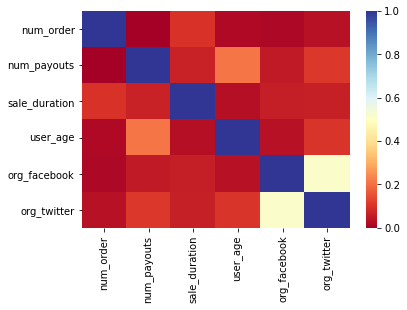

In [14]:
# sales duration 1 and sales duration 2 have high correlation REMOVED
sns.heatmap(numeric_corr, xticklabels=numeric_corr.columns, yticklabels=numeric_corr.columns, cmap='RdYlBu');

# Feature Engineering & Preprocessing

In [15]:
fraud_df = fraud_df.where(pd.notnull(fraud_df), np.nan)

In [16]:
X_fraud = fraud_df.loc[:, cols]
y_fraud = fraud_df.target
X_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num_order        14337 non-null  int64  
 1   num_payouts      14337 non-null  int64  
 2   sale_duration    14182 non-null  float64
 3   user_age         14337 non-null  int64  
 4   org_facebook     14278 non-null  float64
 5   org_twitter      14278 non-null  float64
 6   channels         14337 non-null  int64  
 7   country          14256 non-null  object 
 8   delivery_method  14321 non-null  float64
 9   email_domain     14337 non-null  object 
 10  fb_published     14337 non-null  int64  
 11  gts              14337 non-null  float64
 12  has_analytics    14337 non-null  int64  
 13  has_header       8928 non-null   float64
 14  has_logo         14337 non-null  int64  
 15  listed           14337 non-null  object 
 16  payout_type      14337 non-null  object 
 17  show_map    

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_fraud, y_fraud, stratify=y_fraud)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10752, 20), (3585, 20), (10752,), (3585,))

In [18]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler())
])
numeric_transformer.fit_transform(fraud_df.loc[:,numeric_cols][:5]).shape

(5, 6)

In [19]:
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
categorical_transformer.fit_transform(fraud_df.loc[:,categorical_cols][:5])

<5x36 sparse matrix of type '<class 'numpy.float64'>'
	with 70 stored elements in Compressed Sparse Row format>

In [20]:
fraud_categorical = categorical_transformer.fit_transform(fraud_df.loc[:,categorical_cols]).todense() 
# categorical_corr = pd.DataFrame(fraud_categorical).corr(method='pearson')

In [21]:
# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


logistic_reg = LogisticRegression(solver='liblinear')


# Base Model: Logistic Regression

In [22]:
# Base Model
logistic_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('logistiic_reg', logistic_reg)
])

In [23]:
logistic_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_order', 'num_payouts',
                                                   'sale_duration', 'user_age',
                                                   'org_facebook',
                                                   'org_twitter']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                               

In [24]:
logistic_pipe.score(X_train, y_train), logistic_pipe.score(X_test, y_test)

(0.9796316964285714, 0.9662482566248256)

In [25]:
y_pred = logistic_pipe.predict(X_test)

In [26]:
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[3235,   27],
       [  94,  229]])

''

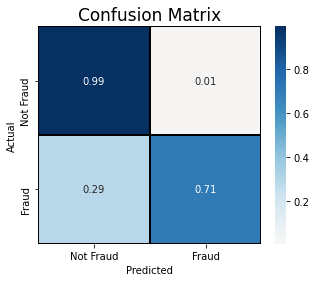

In [27]:
cm = confusion/confusion.sum(axis=1).reshape(-1,1)

fig, ax = plt.subplots(1, figsize = (5,4))
sns.heatmap(cm,annot=True, cmap='RdBu', ax = ax, fmt='.2f', cbar=True, center = 0.02, \
            linewidths=1, linecolor='k',  yticklabels=['Not Fraud', 'Fraud'], xticklabels=['Not Fraud', 'Fraud'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix', fontsize=17)



;

In [28]:
# our model predicted that 31% will be legitimate transaction when they were in fact should have been fraud alert
print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.97      0.99      0.98      3262
       Fraud       0.89      0.71      0.79       323

    accuracy                           0.97      3585
   macro avg       0.93      0.85      0.89      3585
weighted avg       0.96      0.97      0.96      3585



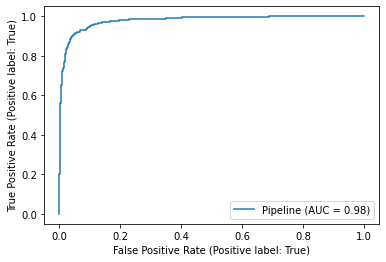

In [29]:
fig, ax = plt.subplots()
plot_roc_curve(logistic_pipe, X_test, y_test, ax=ax );

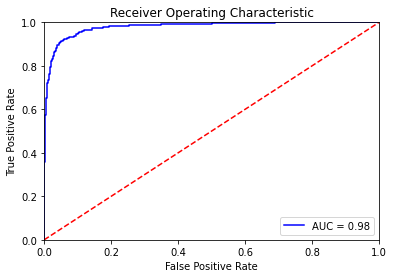

In [30]:
probs = logistic_pipe.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
def evaluation_metrics(pipe):
    fig, axs = plt.subplots(3, figsize = (6,12))
    fig.tight_layout(pad=3)
    
    y_pred = pipe.predict(X_test)
    confusion = confusion_matrix(y_test, y_pred)
    cm = confusion/confusion.sum(axis=1).reshape(-1,1)

    sns.heatmap(cm,annot=True, cmap='RdBu', ax = axs[0], fmt='.2f', cbar=True, center = 0.02, \
                linewidths=1, linecolor='k',  yticklabels=['Not Fraud', 'Fraud'], xticklabels=['Not Fraud', 'Fraud'])
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')
    axs[0].set_title('Confusion Matrix', fontsize=17)
    
    print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))
    
    roc = plot_roc_curve(pipe, X_test, y_test, ax=axs[1] )
    roc.ax_.set_title('Receiver Operating Characterstic', fontsize=17)
    precision_recall = plot_precision_recall_curve(pipe, X_test, y_test, ax=axs[2])
    precision_recall.ax_.set_title('Precision-Recall curve', fontsize=17)
    

              precision    recall  f1-score   support

   Not Fraud       0.97      0.99      0.98      3262
       Fraud       0.89      0.71      0.79       323

    accuracy                           0.97      3585
   macro avg       0.93      0.85      0.89      3585
weighted avg       0.96      0.97      0.96      3585



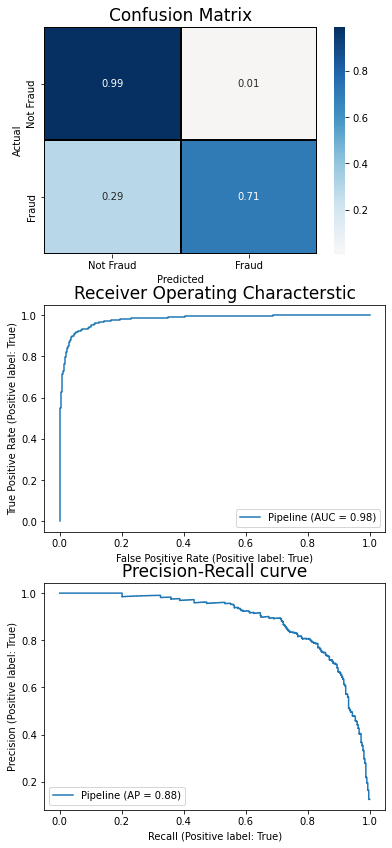

In [32]:
evaluation_metrics(logistic_pipe)

# Random Forest

In [49]:
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

rf_param_grid = [
    {'classifier': [LogisticRegression()],
     'classifier__penalty': ['l1', 'l2'],
     'classifier__C': np.logspace(-4,4,10),
     'classifier__solver': ['liblinear']
    }, 
    {'classifier': [RandomForestClassifier()],
     'classifier__n_estimators': list(range(50,201,10)),
     'classifier__max_features': list(range(3,20, 5))
    
    }
    
]

In [51]:
rf_clf = GridSearchCV(rf_pipe, rf_param_grid, cv=5, verbose=True, n_jobs=-1)
rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_order',
                                                                          'num_payouts',
                                                                          'sale_duration',
                                                                          'user_age',
                                                                          '

In [53]:
rf_clf.cv_results_

{'mean_fit_time': array([ 0.41836257,  0.40918884,  0.38383265,  0.40188713,  0.41536055,
         0.40647569,  0.4836617 ,  0.40233636,  0.61896663,  0.42016463,
         1.28018284,  0.50977097,  1.21200256,  0.60023198,  1.12287335,
         0.7540103 ,  1.31064377,  0.92343054,  1.37040758,  1.05458741,
         3.01995311,  3.51174831,  4.06922984,  4.49047775,  5.02617583,
         5.58881931,  6.10169244,  6.51270609,  7.02772675,  7.54780574,
         8.04083772,  8.60098281,  9.06918502,  9.55481744, 10.23711982,
        10.78788433,  2.79610243,  3.2913208 ,  3.75201035,  4.17166133,
         4.65213861,  5.12501345,  5.56268196,  6.04415922,  6.53961596,
         7.00059509,  7.42979298,  7.90650134,  8.44796557,  8.91963439,
         9.36801586,  9.86680527,  2.67838411,  3.19160957,  3.62680449,
         4.08190928,  4.71558499,  5.03849373,  5.40554914,  5.84500117,
         6.3336648 ,  6.76280742,  7.20575061,  7.76166773,  8.54702134,
         8.84012227,  9.03742375, 

In [55]:
rf_clf.best_params_

{'classifier': RandomForestClassifier(max_features=3, n_estimators=140),
 'classifier__max_features': 3,
 'classifier__n_estimators': 140}

In [57]:
rf_best_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=200, max_features=8))
])

rf_best_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_order', 'num_payouts',
                                                   'sale_duration', 'user_age',
                                                   'org_facebook',
                                                   'org_twitter']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                               

              precision    recall  f1-score   support

   Not Fraud       0.98      1.00      0.99      3262
       Fraud       0.97      0.77      0.86       323

    accuracy                           0.98      3585
   macro avg       0.97      0.89      0.92      3585
weighted avg       0.98      0.98      0.98      3585



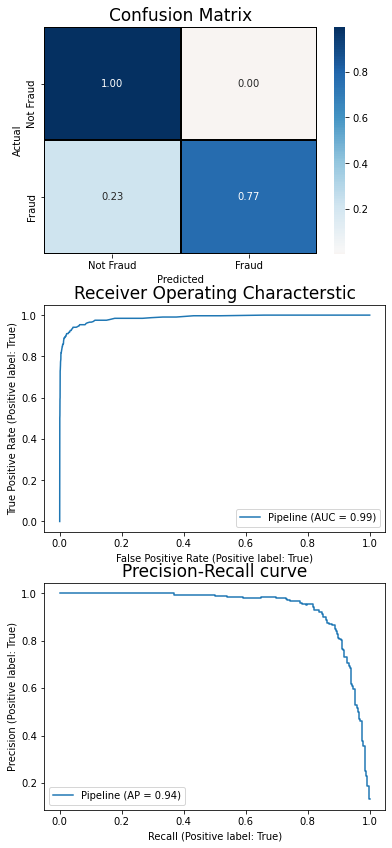

In [59]:
evaluation_metrics(rf_best_pipe)

# Gradient Boosting

In [61]:
gb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

gb_param_grid = [
    {'classifier__max_depth': [3,5,7],
     'classifier__max_features': [None, 'sqrt'],
     'classifier__min_samples_split': [2,6],
     'classifier__loss': ['deviance', 'exponential'],
     'classifier__learning_rate': [0.1],
     'classifier__n_estimators': list(range(100,301,50)),
     'classifier__subsample': [0.5, 1]
    }] 

gb_clf = GridSearchCV(gb_pipe, gb_param_grid, cv=3, verbose=True, n_jobs=-1)


In [63]:
gb_clf.fit(X_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_order',
                                                                          'num_payouts',
                                                                          'sale_duration',
                                                                          'user_age',
                                                                          '

In [65]:
gb_clf.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [66]:
gb_best_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('gb', GradientBoostingClassifier(
                       learning_rate = 0.01,
                       loss = 'deviance',
                       max_depth =  7,
                       max_features = None,
                        min_samples_split = 2,
                        n_estimators = 250,
                        subsample = 1))
])

gb_best_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_order', 'num_payouts',
                                                   'sale_duration', 'user_age',
                                                   'org_facebook',
                                                   'org_twitter']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                               

              precision    recall  f1-score   support

   Not Fraud       0.98      0.99      0.99      3262
       Fraud       0.91      0.81      0.86       323

    accuracy                           0.98      3585
   macro avg       0.95      0.90      0.92      3585
weighted avg       0.98      0.98      0.98      3585



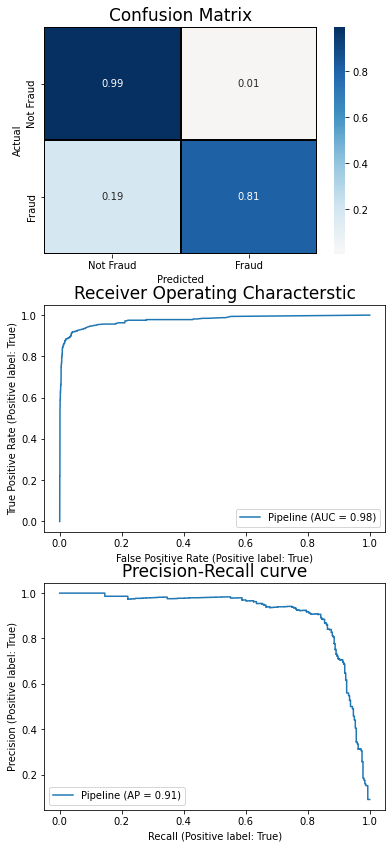

In [67]:
evaluation_metrics(gb_best_pipe)

In [68]:
rf_clf

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_order',
                                                                          'num_payouts',
                                                                          'sale_duration',
                                                                          'user_age',
                                                                          '

### Mandy

In [72]:
X_train.iloc[1].values

array([10, 5, 127.0, 4, 0.0, 0.0, 8, 'US', 1.0, 'gmail.com', 0, 1486.9, 0,
       0.0, 1, 'y', 'CHECK', 1, 3, 'US'], dtype=object)

In [74]:
X_train.iloc[1]

num_order                 10
num_payouts                5
sale_duration          127.0
user_age                   4
org_facebook             0.0
org_twitter              0.0
channels                   8
country                   US
delivery_method          1.0
email_domain       gmail.com
fb_published               0
gts                   1486.9
has_analytics              0
has_header               0.0
has_logo                   1
listed                     y
payout_type            CHECK
show_map                   1
user_type                  3
venue_country             US
Name: 12035, dtype: object

In [83]:
rf_best_pipe.predict(X_train)

array([False, False, False, ..., False, False, False])

In [84]:
X_test.head()

,num_order,num_payouts,sale_duration,user_age,org_facebook,org_twitter,channels,country,delivery_method,email_domain,fb_published,gts,has_analytics,has_header,has_logo,listed,payout_type,show_map,user_type,venue_country
6377,9,5,22.0,558,18.0,14.0,11,GB,1.0,designerforum.org.uk,0,495.21,0,NaN,1,y,ACH,1,3,GB
4252,8,236,40.0,550,10.0,8.0,0,US,1.0,jhilburn.com,0,340.00,0,1.0,1,n,ACH,1,4,US
10693,19,5,51.0,337,14.0,12.0,8,GB,0.0,key-words.co.uk,0,184.73,0,NaN,1,y,ACH,1,4,GB
7126,78,10,225.0,0,0.0,0.0,11,GB,1.0,urban-change-in-iran.org,0,11701.41,0,0.0,1,y,ACH,1,1,GB
7565,248,0,126.0,0,0.0,0.0,0,US,1.0,gmail.com,0,5635.35,0,0.0,1,n,ACH,0,1,US


In [77]:
X_train.iloc[1].values.reshape(-1,1)

array([[10],
       [5],
       [127.0],
       [4],
       [0.0],
       [0.0],
       [8],
       ['US'],
       [1.0],
       ['gmail.com'],
       [0],
       [1486.9],
       [0],
       [0.0],
       [1],
       ['y'],
       ['CHECK'],
       [1],
       [3],
       ['US']], dtype=object)